## 중첩행렬을 이용한 작곡

In [1]:
student = 'weight2'
dir_data = './data'

In [2]:
import os
import math
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from academy import Music, train
from academy import OverlapMatrixModel

In [3]:
songname = 'daechita'

music = Music()
music.load_music(os.path.join(dir_data, f'{songname}_allnode.txt'))
music.load_nodelist(os.path.join(dir_data, f'{songname}_nodelist.txt'))
music.load_cycles(os.path.join(dir_data, f'{songname}_intervals.txt'))

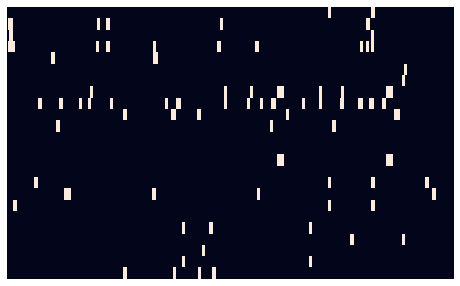

In [4]:
overlap_matrix = music.overlap_matrix

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.heatmap(np.transpose(overlap_matrix), cbar=False)
ax.axis('off')
plt.show()

### 데이터 만들기

In [5]:
length = music.length
n_nodes = music.num_nodes

matrix_used = music.overlap_matrix
overlap_matrix_duplicated = np.concatenate((matrix_used, matrix_used), axis=0)


L_encoded = music.indexed_music
L_onehot = np.zeros((length, n_nodes), dtype=np.bool)
for i, idx in enumerate(L_encoded):
    L_onehot[i, idx] = 1
L_onehot_duplicated = np.concatenate((L_onehot, L_onehot))
L_encoded_duplicated = np.concatenate((L_encoded, L_encoded))

print("The shape of overlap_matrix_duplicated : ", overlap_matrix_duplicated.shape)
print("The shape of L_onehot_duplicated : ", L_onehot_duplicated. shape)
print("The shape of L_encoded_duplicated : ", L_encoded_duplicated. shape)

# Dongjin's implementation April 26
start_indices = music.beat_start_indices()
X = np.stack([overlap_matrix_duplicated[i:i + length].flatten() for i in range(music.length)])
y = np.stack([L_onehot_duplicated[i:i + length].flatten() for i in range(music.length)])
y = np.stack([L_encoded_duplicated[i:i + length].flatten() for i in range(music.length)])

print("The shape of X: ", X.shape)
print("The shape of y: ", y.shape)

X = X.astype(np.float32)
y = y.astype(np.int64)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

dim_input = X.shape[1]
dim_output = y.shape[1] * n_nodes
dim_hidden = length

The shape of overlap_matrix_duplicated :  (1142, 24)
The shape of L_onehot_duplicated :  (1142, 56)
The shape of L_encoded_duplicated :  (1142,)
The shape of X:  (571, 13704)
The shape of y:  (571, 571)


/var/folders/rz/r0y7d9td22z3rxsxfq4_spvr0000gn/T/ipykernel_6646/592430320.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  L_onehot = np.zeros((length, n_nodes), dtype=np.bool)


### 모델 만들기

In [11]:
model = OverlapMatrixModel(dim_input, dim_hidden, dim_output, music.num_nodes)

### 훈련 시키기

In [12]:
weight = len(y.flatten()) / (n_nodes * np.bincount(y.flatten()))
weight = weight.astype(np.float32)
weight = torch.from_numpy(weight).float()

In [14]:
train(model, X_train, torch.from_numpy(y_train.flatten()), epochs=500, task='classification', weight=weight ** 3)

Log:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 결과 확인

In [9]:
overlap_matrix = music.overlap_matrix
X = np.transpose(overlap_matrix)
Generated_Music = np.argmax(model(torch.tensor(X.flatten(), dtype=torch.float32)).detach().numpy(), axis=1)
print(Generated_Music)

[10 10 10  3 19 10  3 19 10 11 10  1 22  5 23 18 11 11 22 11  3 33  3 10
 19 10 11 11 11 22  1 22 10 11 10 11 10 11  4 11  2  2  3 11  1 18 11 10
 11 18 11  3  5 10 11  4 11 10 19 18 18 11 11  2  3  3 19  3 11 22  5 23
 22 11  1  1  2 10 23 10 10 10 19  4 19 10 11  5 11  1 11 10 11  1 11 11
 10 18 11 11  4  1 10 11 11 11 10 11 10 10 23  5 10 23 19 10 10 18 11 11
 19 22 10 10 10 11  3  2 19 10 19 11  5 19 19 10  1  2 22 18 11 11  1 10
  1 11  1 10 19 18 11 11 11 18 11 22 18 11 11  1 10 10  3  3 33 22 10 18
 11 10 10 11 11 10  3 10 11  1 11 10 11 10 11 22  5 18 11 18  1  4  5  3
 22  3 11 11 10 10 19 10 10 11 10 11 10 10 18 11 11  1 10 19 22 18 11 11
 19 10 10 11 11 10  4 11  4 11 11 11 11 11 11  5 11 10 10 19 10 19 10 10
 10 18 11 11 11 11 11 10 19 19 19 19 10 18 11 18 11 22 10 11 33 10 11 33
 10 10 33  1 19  9 19 10 10 10 11 19 22 19 22 10  5 10 11 11  1  2  3 11
 22  3  5 11 10  5 19 11 11 19 11 11 11 11 11 19 11  1 11 19 11 11 19 10
 19 10 10 11 11  5 22  1 10 19 10 10 10 11 10  2 19

In [10]:
import pandas as pd
left_df = pd.value_counts(music.indexed_music, sort=False).reset_index()
left_df.columns = ['node', 'freq']

right_df = pd.value_counts(Generated_Music, sort=False).reset_index()
right_df.columns = ['node', 'freq']

left_df.merge(right=right_df, on='node', how='left')

,node,freq_x,freq_y
0,0,2,NaN
1,1,29,38.0
2,2,26,11.0
3,3,27,29.0
4,4,24,14.0
5,5,25,24.0
6,6,1,NaN
7,7,6,NaN
8,8,9,NaN
9,9,14,2.0


In [19]:
pitch = np.array(['rest', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'B5', 'C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'A#6', 'B6'])
aria  = np.array([0, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36])
freq  = np.array([0, 131, 139, 147, 156, 165, 175, 185, 196, 208, 220, 233, 247, 262, 277, 294, 311, 330, 349, 370, 392, 415, 440, 466, 494, 523, 554, 587, 622, 659, 698, 740, 784, 831, 880, 932, 988, 1047, 1109, 1175, 1245, 1319, 1397, 1480, 1568, 1661, 1760, 1865, 1976])

freq2aria = {f: a for f, a in zip(freq, aria)}
freq2pitch = {f: p for f, p in zip(freq, pitch)}

freqlist = np.floor(music.nodelist).astype(int)
pitchlist = np.array([freq2pitch[f] for f in freqlist])
midilist = 131 - np.array([freq2aria[f] for f in freqlist])

p = freqlist
m = midilist
t = np.array([int(str(i).split('.')[1]) / 24 for i in music.nodelist])

####### Cycle pitch + tempo function ##################
def cycle_generate(cycle_number, m, t):
    cycle = []
    n = len(cycle_number)
    for i in range(n):
        c = cycle_number[i]
        midi = m[c]
        tempo = t[c]
        cycle.append([midi, tempo])
    return cycle

def choose_node(z, m, t):
    
    node_current = cycle_generate([z], m, t)
    int_midi_number=node_current[0][0]
    int_midi_duration=node_current[0][1]
    if node_current[0][0] == 131:
        n1 = note.Rest()
    else:
        n1 = note.Note(int_midi_number)
    n1.duration = duration.Duration(4 * int_midi_duration)
    
    return n1

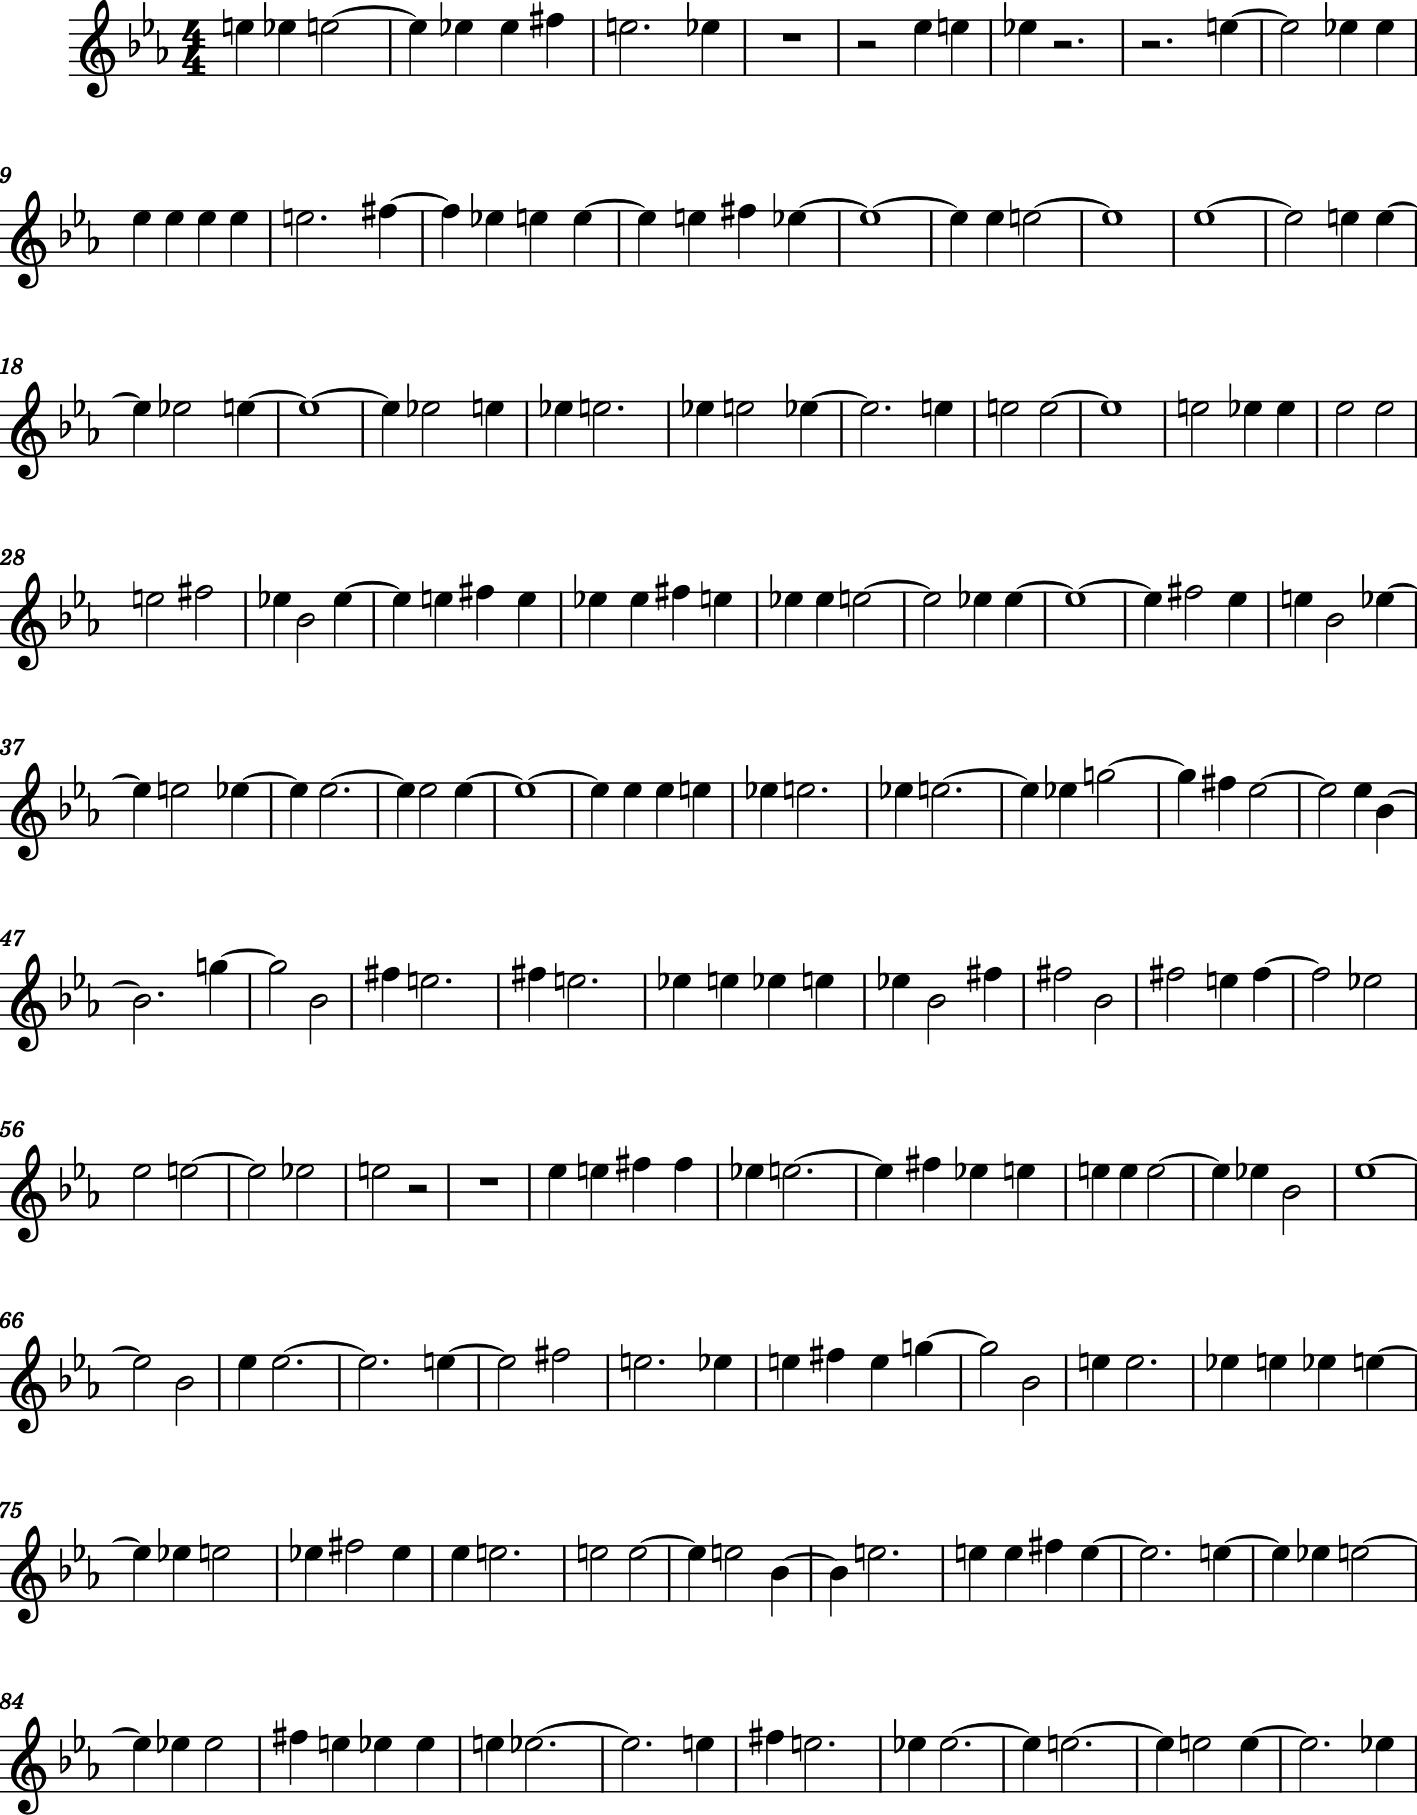

PosixPath('/Users/dongjin/Library/CloudStorage/OneDrive-postech.ac.kr/projects/academy2th/weight1_daechita.pdf')

In [20]:
###########################
# From node to new music 
from music21 import *

s1 = stream.Stream()
s1.clear()
s1.insert(0, meter.TimeSignature('4/4'))
s1.keySignature= key.KeySignature(-3)

#node_sequence = loadtxt('Generated_Music_allnode_8.txt')
node_sequence = Generated_Music

N = len(node_sequence)

for i in range(N):
    z = int(node_sequence[i])
    n1 = choose_node(z, m, t)
    s1.append(n1)

s1.show()

NewComposition=stream.Stream()
NewComposition.clear()
NewComposition.insert(0, meter.TimeSignature('4/4'))
NewComposition.keySignature= key.KeySignature(-3)
NewComposition.append(s1)
NewComposition.show('midi')
NewComposition.write("midi", "generated_daechita.mid")
NewComposition.write("musicxml.pdf", f"{student}_daechita.pdf")